# Step 1. Create and Train an AutoEncoder that would learn the patterns of the normal sensor reading

In [137]:
import pandas as pd

In [138]:
df = pd.read_csv('dataset_preprocessed.csv')
# df['Monitor_Category'] = df['Monitor_Category'].map({'No Activity':0, 'Activity':1})

df.head()

,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,hand magnetometer Y,...,ankle acceleration X ±16g,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,Monitor_Category
0,0.247619,0.0,0.845420,0.477510,0.226147,0.402513,0.721178,0.514036,0.362942,0.391370,...,0.296982,0.493712,0.613909,0.471061,0.549782,0.552562,0.413018,0.378801,0.218481,No Activity
1,0.247619,0.0,0.844225,0.477323,0.227056,0.404957,0.720885,0.515119,0.363824,0.391334,...,0.297156,0.493958,0.613376,0.470461,0.548805,0.553417,0.417977,0.379061,0.216851,No Activity
2,0.247619,0.0,0.845429,0.477512,0.226378,0.403747,0.720393,0.514466,0.361173,0.390226,...,0.296632,0.493464,0.614795,0.470848,0.549141,0.554470,0.414692,0.377063,0.217387,No Activity
3,0.247619,0.0,0.843486,0.477126,0.227046,0.405752,0.720401,0.514623,0.363790,0.390136,...,0.296626,0.493343,0.614618,0.470854,0.547703,0.553936,0.415902,0.379553,0.217405,No Activity
4,0.247619,0.0,0.844491,0.478735,0.227285,0.406279,0.719931,0.512217,0.366495,0.392835,...,0.297176,0.493710,0.614088,0.471238,0.548125,0.553265,0.411794,0.377162,0.217944,No Activity


In [139]:
X_activity = df[df['Monitor_Category'] == "Activity"].drop(columns=['Monitor_Category'])
X_noactivity = df[df['Monitor_Category'] == "No Activity"].drop(columns=['Monitor_Category'])

In [140]:
import torch
from torch import nn

In [141]:
class AnomalyDetection(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Linear(31, 20)

    self.decoder = nn.Linear(20, 31)

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

In [142]:
model = AnomalyDetection()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

epochs = 10
batch_size = 25

In [143]:
X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

In [144]:
loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch{0} Step {1}: Loss - {2}'.format(epoch+1, i, loss), end='\r')

In [145]:
activity_loss = []

size = 10000

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss.append(loss.item())

noactivity_loss = []

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss.append(loss.item())


In [146]:
df_activity = pd.DataFrame(activity_loss, columns=['value'])
df_activity['category'] = 'activity'

df_noactivity = pd.DataFrame(noactivity_loss, columns=['value'])
df_noactivity['category'] = 'noactivity'

df_full = pd.concat([df_noactivity, df_activity])
df_full.head()

,value,category
0,0.046991,noactivity
1,0.047064,noactivity
2,0.047018,noactivity
3,0.047031,noactivity
4,0.046742,noactivity


# Step 2. Determine a suitable Threshold for the Anomaly Detection System using the Loss of the AutoEncoder

<Axes: xlabel='value', ylabel='Count'>

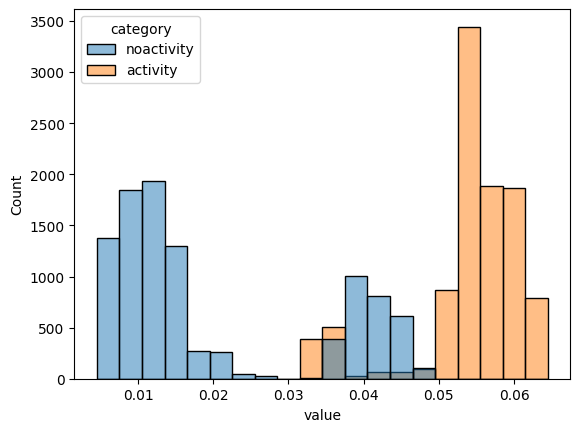

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot(data=df_full, x='value', hue='category')
fig, ax1 = plt.subplots(1, 1)

sns.histplot(data=df_full, x='value', hue='category', ax=ax1)
# ax1.set_ylim([0, 50])

a. Show Visual Proof using Histograms to show why that Threshold is the best for the task

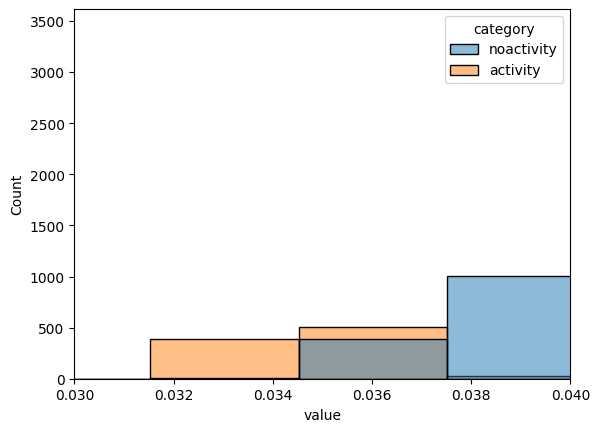

In [157]:
ax1.set_xlim([0.03, 0.04])

fig

In [166]:
threshold = 0.04

test_normal = X_activity_tensor[5]
test_anomaly = X_noactivity_tensor[5]

reconst_normal = model(test_normal)
reconst_anomaly = model(test_anomaly)

loss_normal = loss_fn(reconst_normal, test_normal)
loss_anomaly = loss_fn(reconst_anomaly, test_anomaly)

print(loss_normal < threshold, loss_anomaly < threshold)

tensor(True) tensor(False)


# 3. Answer the Following Questions at the end of the Python Notebook

a. Try to recreate the model, but use a smaller latent vector. What happened in this case and why do you think this happened?

In [106]:
class AnomalyDetectionSmallLatent(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Linear(31, 5)

    self.decoder = nn.Linear(5, 31)

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

model = AnomalyDetectionSmallLatent()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch{0} Step {1}: Loss - {2}'.format(epoch+1, i, loss), end='\r')

<Axes: xlabel='value', ylabel='Count'>

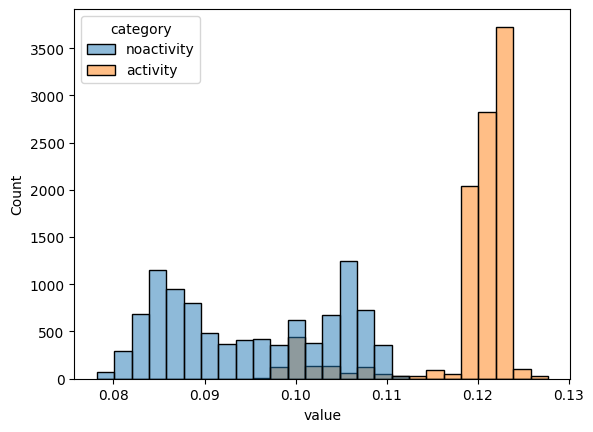

In [124]:
activity_loss_small = []

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss_small.append(loss.item())

noactivity_loss_small = []

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss_small.append(loss.item())

df_activity_small = pd.DataFrame(activity_loss_small, columns=['value'])
df_activity_small['category'] = 'activity'

df_noactivity_small = pd.DataFrame(noactivity_loss_small, columns=['value'])
df_noactivity_small['category'] = 'noactivity'

df_full_small = pd.concat([df_noactivity_small, df_activity_small])
# df_full.head()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots(1, 1)
sns.histplot(data=df_full_small, x='value', hue='category')

b. Try to recreate the model where the latent vector is bigger in size than the input
vector. What happened in this case and why do you think happened?

In [108]:
class AnomalyDetectionBigLatent(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Linear(31, 50)

    self.decoder = nn.Linear(50, 31)

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

model = AnomalyDetectionBigLatent()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch{0} Step {1}: Loss - {2}'.format(epoch+1, i, loss), end='\r')

<Axes: xlabel='value', ylabel='Count'>

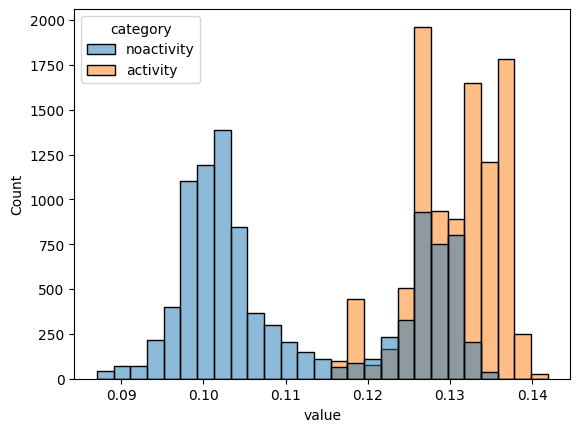

In [125]:
activity_loss_big = []

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss_big.append(loss.item())

noactivity_loss_big = []

for i in range(0, size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss_big.append(loss.item())

df_activity_big = pd.DataFrame(activity_loss, columns=['value'])
df_activity_big['category'] = 'activity'

df_noactivity_big = pd.DataFrame(noactivity_loss, columns=['value'])
df_noactivity_big['category'] = 'noactivity'

df_full_big = pd.concat([df_noactivity, df_activity])
# df_full.head()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots(1, 1)
sns.histplot(data=df_full_big, x='value', hue='category')